# Se importan las bibliotecas necesarias

In [1]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostRegressor
%matplotlib inline

# Se lee el .csv

In [2]:
train = pd.read_csv('csv/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('csv/test.csv')

In [5]:
res_modelo2 = pd.read_csv('csv/solo_embedding.csv')
del res_modelo2['Unnamed: 0']
res_modelo2.head()

,0
0,0.771458
1,0.606724
2,0.879399
3,0.944014
4,0.894664


In [6]:
res_modelo2_test = pd.read_csv('csv/solo_embedding_test.csv')
del res_modelo2_test['Unnamed: 0']
res_modelo2_test.head()

,0
0,0.869460
1,0.561893
2,0.709307
3,0.601553
4,0.532795


In [7]:
train['res_modelo2'] = res_modelo2.iloc[:, 0]
train.head()

,id,keyword,location,text,target,res_modelo2
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664


In [8]:
test['res_modelo2'] = res_modelo2_test.iloc[:, 0]
test.head()

,id,keyword,location,text,res_modelo2
0,0,NaN,NaN,Just happened a terrible car crash,0.869460
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.561893
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.709307
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.601553
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.532795


# Elaboración del modelo

Para este modelo se utilizarán árboles de decisión para realizar las predicciones y se tendrán en cuenta los siguientes features extraídos del análisis exploratorio, los cuales fueron seleccionados por el grupo como aquellos que podrían resultan más interesantes:

- Palabras con mayor y menor porcentaje de veracidad.
- Pares de 2 palabras con mayor y menor porcentaje de veracidad.
- Tweets que contienen @, ¿?, ¡! tienden a ser falsos.
- Keywords con mayor y menor porcentaje de veracidad.
- Locaciones más y menos veraces.
- Longitud.

### Preparación del set de datos

#### Parte inicial

In [9]:
#Palabras con mayor y menor porcentaje de veracidad
min_repetitions = ((0.2/100)*len(train.index))
words = train['text'].str.split()
clean_words = []

for sentence in words:
    clean_sentence = []
    for word in sentence:
        clean_word = re.sub('[^A-Za-z0-9]+','', word)
        if(clean_word != ''):
            clean_sentence.append(clean_word.lower())
    clean_words.append(clean_sentence)

In [10]:
train_aux = train
train_aux['words'] = clean_words
train_aux = train_aux.explode('words')
train_aux.head()

,id,keyword,location,text,target,res_modelo2,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,our
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,deeds
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,are
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,the
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,reason


In [11]:
#Palabras con mayor y menor porcentaje de veracidad (TEST, CREO QUE SEPARA LOS TWEETS POR PALABRAS)***********
#min_repetitions = ((0.2/100)*len(test.index))
#words = test['text'].str.split()
#clean_words = []

#for sentence in words:
#    clean_sentence = []
#    for word in sentence:
#        clean_word = re.sub('[^A-Za-z0-9]+','', word)
#        if(clean_word != ''):
#            clean_sentence.append(clean_word.lower())
#    clean_words.append(clean_sentence)
#test_aux = test
#test_aux['words'] = clean_words
#test_aux = test_aux.explode('words')
#test_aux.head()

In [12]:
train_aux = train_aux.groupby('words').agg({'target':['sum','count']})
train_aux = train_aux[train_aux['target']['count']>min_repetitions]
train_aux['veracity'] = train_aux['target']['sum']/train_aux['target']['count']
train_aux.head()

target        veracity
         sum count          
words                       
05        14    18  0.777778
1         29    64  0.453125
10         9    23  0.391304
100        6    17  0.352941
11         7    21  0.333333

In [13]:
train_aux.reset_index(inplace=True) 

In [14]:
#Pares de 2 palabras con mayor y menor porcentaje de veracidad.
train_aux2 = train
train_aux2['words'] = clean_words
words_pairs = []

for sentence in train_aux2['words']:
    pairs = []
    for i in range(len(sentence)-1):
        pairs.append(sentence[i] + ' ' + sentence[i+1])
    words_pairs.append(pairs)
    
train_aux2['words'] = words_pairs
train_aux2 = train_aux2.explode('words')
train_aux2.head()

,id,keyword,location,text,target,res_modelo2,words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,our deeds
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,deeds are
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,are the
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,the reason
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,reason of


In [15]:
train_aux2 = train_aux2.groupby('words').agg({'target':['sum','count']})
train_aux2 = train_aux2[train_aux2['target']['count']>min_repetitions]
train_aux2['veracity'] = train_aux2['target']['sum']/train_aux2['target']['count']

In [16]:
#las palabras que son '' la cagan
train_aux2.head(10)

target        veracity
                 sum count          
words                               
11yearold boy     20    20  1.000000
16yr old          28    28  1.000000
40 families       26    26  1.000000
70 years          30    31  0.967742
a blast            3    16  0.187500
a car              9    16  0.562500
a cliff            8    24  0.333333
a few              8    18  0.444444
a fire             8    16  0.500000
a good             5    16  0.312500

In [17]:
train_aux2.reset_index(inplace=True)

In [18]:
# Keywords más y menos veraces
train_aux3 = train
train_aux3 = train_aux3.groupby('keyword').agg({'target':['sum','count']})
train_aux3 = train_aux3[train_aux3['target']['count']>min_repetitions]
train_aux3['veracity'] = train_aux3['target']['sum']/train_aux3['target']['count']
train_aux3.head()

target        veracity
                       sum count          
keyword                                   
ablaze                  13    36  0.361111
accident                24    35  0.685714
aftershock               0    34  0.000000
airplane%20accident     30    35  0.857143
ambulance               20    38  0.526316

In [19]:
train_aux3.reset_index(inplace=True)

In [20]:
# Locaciones más y menos veraces
train_aux4 = train
train_aux4 = train_aux4.groupby('location').agg({'target':['sum','count']})
train_aux4 = train_aux4[train_aux4['target']['count']>min_repetitions]
train_aux4['veracity'] = train_aux4['target']['sum']/train_aux4['target']['count']
train_aux4.head()

target        veracity
               sum count          
location                          
Australia        9    18  0.500000
California       7    17  0.411765
Canada          13    29  0.448276
Chicago, IL      9    18  0.500000
India           20    24  0.833333

In [21]:
train_aux4.reset_index(inplace=True)

#### Parte final

In [22]:
top_words = train_aux[train_aux['veracity']>0.9]['words']
worst_words = train_aux[train_aux['veracity']<0.1]['words']

In [23]:
top_words_pairs = train_aux2[train_aux2['veracity']>0.9]['words']
worst_words_pairs = train_aux2[train_aux2['veracity']<0.1]['words']

In [24]:
top_keywords = train_aux3[train_aux3['veracity']>0.9]['keyword']
worst_keywords = train_aux3[train_aux3['veracity']<0.1]['keyword']

In [25]:
top_locations = train_aux4[train_aux4['veracity']>0.9]['location']
worst_locations = train_aux4[train_aux4['veracity']<0.1]['location']

In [26]:
train = train.drop(columns='words')
train['long(char)'] = train['text'].str.len()

aux = []
for i in words:
    aux.append(len(i))

train['long(word)'] = aux
train.head()

,id,keyword,location,text,target,res_modelo2,long(char),long(word)
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,88,16


In [27]:
def count_text_ocurrences(texts, words):
    ocurrences = []
    for text in texts:
        count = 0
        for word in words:
            if word in text:
                count = count+1
        ocurrences.append(count)
    return ocurrences

def count_ocurrences(searched, series):
    ocurrences = []
    for element in searched:
        count = 0
        if element in series:
            count = count+1
        ocurrences.append(count)
    return ocurrences

def contains_char(texts, char1, char2=''):
    ocurrences = []
    for text in texts:
        count = 0
        if char1 in text:
            count = 1
        if (count==0)&(char2!=''):
            if char2 in text:
                count = 1
        ocurrences.append(count)
    return ocurrences

In [28]:
train['top_words'] = count_text_ocurrences(train['text'], top_words)
train['worst_words'] = count_text_ocurrences(train['text'], worst_words)
train['top_words_pairs'] = count_text_ocurrences(train['text'], top_words_pairs)
train['worst_words_pairs'] = count_text_ocurrences(train['text'], worst_words_pairs)
train.head()

,id,keyword,location,text,target,res_modelo2,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,69,13,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,38,7,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,133,22,1,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,65,8,1,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,88,16,1,0,0,0


In [29]:
train['top_keywords'] = count_ocurrences(train['keyword'], top_keywords)
train['worst_keywords'] = count_ocurrences(train['keyword'], worst_keywords)
train['top_locations'] = count_ocurrences(train['location'], top_locations)
train['worst_locations'] = count_ocurrences(train['location'], worst_locations)
train.head()

,id,keyword,location,text,target,res_modelo2,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,69,13,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,38,7,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,133,22,1,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,65,8,1,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,88,16,1,0,0,0,0,0,0,0


In [30]:
train['arroba'] = contains_char(train['text'],'@')
train['singnosDeInterrogacion'] = contains_char(train['text'],'\?', '¿')
train['signosDeExclamacion'] = contains_char(train['text'],'!','¡')
train.head()

,id,keyword,location,text,target,res_modelo2,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,arroba,singnosDeInterrogacion,signosDeExclamacion
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.771458,69,13,0,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.606724,38,7,0,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.879399,133,22,1,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.944014,65,8,1,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.894664,88,16,1,0,0,0,0,0,0,0,0,0,0


In [31]:
train = train.drop(columns=['keyword','location','text'])
train = train.set_index('id')
train.head(20)

,target,res_modelo2,long(char),long(word),top_words,worst_words,top_words_pairs,worst_words_pairs,top_keywords,worst_keywords,top_locations,worst_locations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,
1,1,0.771458,69,13,0,0,0,0,0,0,0,0,0,0,0
4,1,0.606724,38,7,0,0,0,0,0,0,0,0,0,0,0
5,1,0.879399,133,22,1,0,0,0,0,0,0,0,0,0,0
6,1,0.944014,65,8,1,0,0,0,0,0,0,0,0,0,0
7,1,0.894664,88,16,1,0,0,0,0,0,0,0,0,0,0
8,1,0.952795,110,18,1,0,0,0,0,0,0,0,0,0,0
10,1,0.973386,95,14,0,0,0,0,0,0,0,0,0,0,0
13,1,0.550996,59,15,0,0,1,0,0,0,0,0,0,0,0
14,1,0.713014,79,12,0,0,0,0,0,0,0,0,0,0,0


In [32]:
col_rename = {'long(char)': 'longEnChars', 'long(word)': 'longEnWords', 'top_words': 'topWords', 'worst_words': 'worstWords', 'top_words_pairs': 'topWordsPairs',  
             'worst_words_pairs': 'worstWordsPairs', 'top_keywords': 'topKeywords', 'worst_keywords': 'worstKeywords', 'top_locations': 'topLocations', 
             'worst_locations': 'worstLocations'}
train = train.rename(columns= col_rename)
train.head(20)

,target,res_modelo2,longEnChars,longEnWords,topWords,worstWords,topWordsPairs,worstWordsPairs,topKeywords,worstKeywords,topLocations,worstLocations,arroba,singnosDeInterrogacion,signosDeExclamacion
id,,,,,,,,,,,,,,,
1,1,0.771458,69,13,0,0,0,0,0,0,0,0,0,0,0
4,1,0.606724,38,7,0,0,0,0,0,0,0,0,0,0,0
5,1,0.879399,133,22,1,0,0,0,0,0,0,0,0,0,0
6,1,0.944014,65,8,1,0,0,0,0,0,0,0,0,0,0
7,1,0.894664,88,16,1,0,0,0,0,0,0,0,0,0,0
8,1,0.952795,110,18,1,0,0,0,0,0,0,0,0,0,0
10,1,0.973386,95,14,0,0,0,0,0,0,0,0,0,0,0
13,1,0.550996,59,15,0,0,1,0,0,0,0,0,0,0,0
14,1,0.713014,79,12,0,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del set de datos

In [33]:
X, y = train.iloc[:,1:-1], train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=465)

#### XGBoost

In [34]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 80)

In [35]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
preds = xg_reg.predict(X_test)

Accuracy Score : 0.9605954465849387
Precision Score : 0.959758551307847
Recall Score : 0.950199203187251
F1 Score : 0.954954954954955


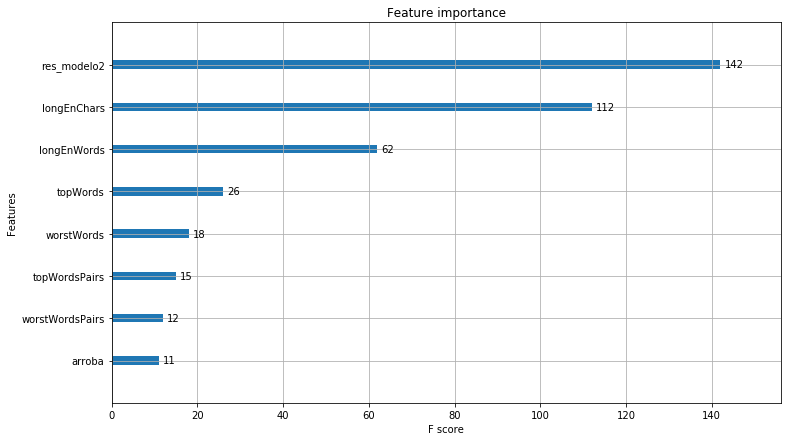

In [37]:
print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

In [38]:
df = pd.DataFrame(preds)
final = df.to_csv('csv/xgboost.csv')
df.head()

,0
0,0.044408
1,0.061382
2,0.154651
3,0.378297
4,0.131910


In [39]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.2, 0.3, 0.4],
#         'max_depth': [10, 15, 20]
#         }
# grid_acc = GridSearchCV(xg_reg, param_grid = params)
# grid_acc.fit(X_train, y_train)
# y_pred_acc = grid_acc.predict(X_test)

# # New Model Evaluation metrics 
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc.round())))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc.round())))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc.round())))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_acc.round())))

#### RandomForest

In [52]:
rf_model = RandomForestRegressor(random_state=13, n_estimators=80, max_depth=20)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

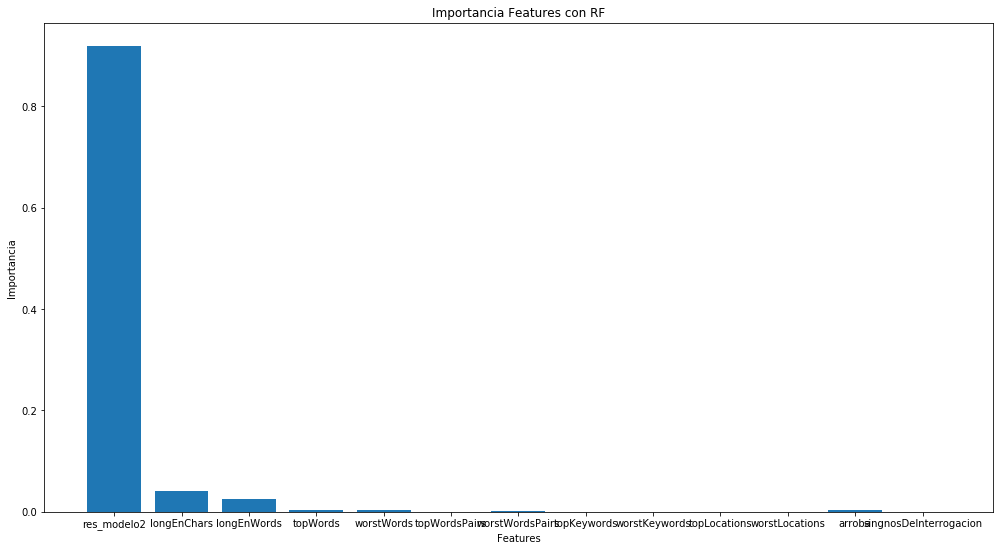

In [53]:
rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [41]:
df = pd.DataFrame(preds)
final = df.to_csv('csv/randomForest.csv')
df.head()

,0
0,0.000000
1,0.000000
2,0.398747
3,0.200594
4,0.063661


rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

#### LightGBM

In [42]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
     'objective': 'regression',
     'metric': 'rmse',
     'num_leaves': 5,
     'learning_rate': 0.1,
     'feature_fraction': 0.9,
 }

params = {
     'objective': 'regression',
 }

gbm = lgb.train(params,
                 lgb_train,
                 num_boost_round=100,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=10)

preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[1]	valid_0's l2: 0.206456
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.173878
[3]	valid_0's l2: 0.147544
[4]	valid_0's l2: 0.125951
[5]	valid_0's l2: 0.108647
[6]	valid_0's l2: 0.0944857
[7]	valid_0's l2: 0.0831051
[8]	valid_0's l2: 0.0738572
[9]	valid_0's l2: 0.066358
[10]	valid_0's l2: 0.0602695
[11]	valid_0's l2: 0.055248
[12]	valid_0's l2: 0.0511669
[13]	valid_0's l2: 0.0479603
[14]	valid_0's l2: 0.0454018
[15]	valid_0's l2: 0.0433256
[16]	valid_0's l2: 0.0415983
[17]	valid_0's l2: 0.0402005
[18]	valid_0's l2: 0.0390784
[19]	valid_0's l2: 0.0381369
[20]	valid_0's l2: 0.0374005
[21]	valid_0's l2: 0.0367678
[22]	valid_0's l2: 0.0362845
[23]	valid_0's l2: 0.0359469
[24]	valid_0's l2: 0.0357063
[25]	valid_0's l2: 0.0355492
[26]	valid_0's l2: 0.0353678
[27]	valid_0's l2: 0.035193
[28]	valid_0's l2: 0.035183
[29]	valid_0's l2: 0.0351297
[30]	valid_0's l2: 0.0351044
[31]	valid_0's l2: 0.03512
[32]	valid_0's l2: 0.035144
[33]	valid_0's l2: 0.0351516
[34

In [43]:
df = pd.DataFrame(preds)
final = df.to_csv('csv/lightgbm.csv')
df.head()

,0
0,0.024845
1,0.076643
2,0.199540
3,0.303906
4,0.115890


#### CatBoost

In [44]:
model = CatBoostRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Learning rate set to 0.054419
0:	learn: 0.4728270	total: 54ms	remaining: 54s
1:	learn: 0.4518698	total: 60.7ms	remaining: 30.3s
2:	learn: 0.4325946	total: 67.9ms	remaining: 22.6s
3:	learn: 0.4144260	total: 71.5ms	remaining: 17.8s
4:	learn: 0.3974573	total: 74.1ms	remaining: 14.7s
5:	learn: 0.3815811	total: 77.5ms	remaining: 12.8s
6:	learn: 0.3667266	total: 80ms	remaining: 11.3s
7:	learn: 0.3531916	total: 82.4ms	remaining: 10.2s
8:	learn: 0.3404065	total: 84.5ms	remaining: 9.3s
9:	learn: 0.3284048	total: 86.4ms	remaining: 8.56s
10:	learn: 0.3172107	total: 88.5ms	remaining: 7.95s
11:	learn: 0.3071354	total: 91.4ms	remaining: 7.52s
12:	learn: 0.2978886	total: 93.2ms	remaining: 7.08s
13:	learn: 0.2890680	total: 95ms	remaining: 6.69s
14:	learn: 0.2806540	total: 96.7ms	remaining: 6.35s
15:	learn: 0.2729771	total: 98.2ms	remaining: 6.04s
16:	learn: 0.2659562	total: 100ms	remaining: 5.79s
17:	learn: 0.2593980	total: 102ms	remaining: 5.55s
18:	learn: 0.2533588	total: 103ms	remaining: 5.33s
19:	

In [45]:
df = pd.DataFrame(preds)
final = df.to_csv('csv/catboost.csv')
df.head()

,0
0,0.003625
1,0.144344
2,0.204996
3,0.222617
4,0.084847


In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Accuracy Score : 0.9588441330998249
Precision Score : 0.9577464788732394
Recall Score : 0.9482071713147411
F1 Score : 0.9529529529529529


/home/hugo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
df = pd.DataFrame(preds)
final = df.to_csv('csv/logicRegression.csv')
df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [48]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 80)
rf_model = RandomForestRegressor(random_state=13, n_estimators=80, max_depth=20)

eclf2 = VotingRegressor(estimators=[
         ('xgb', xg_reg), ('rf', rf_model)])

In [49]:
eclf2 = eclf2.fit(X, y)

In [50]:
preds = eclf2.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Accuracy Score : 0.9763572679509632
Precision Score : 0.9817444219066938
Recall Score : 0.9641434262948207
F1 Score : 0.9728643216080402
